# Анализ тональности киноотзывов

Воспользуемся набором данных, который сидержит киноотзывы, оставленные на сайте IMDb (Internet Movie Database).  
    
Этот набор данных содержит тексты отзывов, а также метки, которые указывают тональность отзыва ("положительный" или "отрицательный"). Сайт IMDb имеет собственую систему оценки фильмов от 1 до 10. Чтобы упростить процесс моделирования, система оценки будет сведена к двум классам: отзывы с оценкой 6 и выше помечаются как "положительные", а остальные отзывы помечаются как "отрицательные".

#### Распакуем данные:

In [1]:
!tree -L 2 /Users/viktorkobets/Documents/aclImdb

/Users/viktorkobets/Documents/aclImdb
├── README
├── imdb.vocab
├── imdbEr.txt
├── test
│   ├── labeledBow.feat
│   ├── neg
│   ├── pos
│   ├── urls_neg.txt
│   └── urls_pos.txt
└── train
    ├── labeledBow.feat
    ├── neg
    ├── pos
    ├── unsup
    ├── unsupBow.feat
    ├── urls_neg.txt
    ├── urls_pos.txt
    └── urls_unsup.txt

7 directories, 11 files


Удалим лишние файлы:

In [2]:
!rm -r /Users/viktorkobets/Documents/aclImdb/test/labeledBow.feat
!rm -r /Users/viktorkobets/Documents/aclImdb/test/urls_neg.txt
!rm -r /Users/viktorkobets/Documents/aclImdb/test/urls_pos.txt
!rm -r /Users/viktorkobets/Documents/aclImdb/train/labeledBow.feat
!rm -r /Users/viktorkobets/Documents/aclImdb/train/unsup
!rm -r /Users/viktorkobets/Documents/aclImdb/train/unsupBow.feat
!rm -r /Users/viktorkobets/Documents/aclImdb/train/urls_neg.txt
!rm -r /Users/viktorkobets/Documents/aclImdb/train/urls_pos.txt
!rm -r /Users/viktorkobets/Documents/aclImdb/train/urls_unsup.txt

Проверим директорию:

In [3]:
!tree -L 2 /Users/viktorkobets/Documents/aclImdb

/Users/viktorkobets/Documents/aclImdb
├── README
├── imdb.vocab
├── imdbEr.txt
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    └── pos

6 directories, 3 files


После распаковки набор данных представляет собой две отдельные папки с текстовыми файлами, одна папка - для обучения, а вторая для - тестирования. Каждая папка в свою очередь содкржит две подпапки, одна называется pos, а другая neg.

Папка pos содержит все положительные отзывы, каждый отзыв записан в виде отдельного текстового файла, папка neg содержит все отрицйательные отзывы и также каждый отзыв представлен в виде отдельного текстового файла.

In [4]:
from sklearn.datasets import load_files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
reviews_train = load_files('/Users/viktorkobets/Documents/aclImdb/train/')
texts_train, label_train = reviews_train.data, reviews_train.target

#### Посмотрим на данные:

Тип данных

In [6]:
type(texts_train)

list

Размер данных

In [7]:
len(texts_train)

25000

Данные

In [8]:
texts_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

Можно увидеть, что подобный отзыв содержит теги разрыва строк HTML, лучше выполнить очистку данных и удалить все символы форматирования перед тем, как начать с ними работу:

In [9]:
texts_train = list(map(lambda x: x.replace(b'<br />', b' '), texts_train))

Проверим данные:

In [10]:
texts_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.  It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see.   Flawed but honest with a terrible honesty."

#### Посмотрим на метки присвоенные отзывам:

Тип меток

In [11]:
type(label_train)

numpy.ndarray

Размер массива меток

In [12]:
label_train.shape

(25000,)

Метки

In [13]:
label_train

array([1, 0, 1, ..., 0, 0, 0])

#### Посмотрм на сбалансированность выборки:

In [14]:
np.bincount(label_train)

array([12500, 12500])

Видим, что число негативных и позитивных отзывов одинаковое, что говорит о верном балансе в выборке.

#### Аналогичным образом загружаем тестовые данные:

In [15]:
reviews_test = load_files('/Users/viktorkobets/Documents/aclImdb/test/')
texts_test, label_test = reviews_test.data, reviews_test.target
texts_test = list(map(lambda x: x.replace(b'<br />', b' '), texts_test))

## Постановка задачи

Задачу можно сформулировать следующим образом: каждому отзыву нужно присвоить метку "положительный" или "отрицательный" на основе анализа его текста. Это стандартная задача бинарной классификации. Однако текстовые данные представлены в формате, который модель машинного обучения не умеет обрабатывать. Необходимо преобразовать строковое представление текста в числовое, к которому можно будет применить алгоритмы машинного обучения.

## Решение:

Представим текстовые данные в виде "мешка слов".

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
vect = CountVectorizer().fit(texts_train)

In [18]:
X_train = vect.transform(texts_train)

In [19]:
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>

Матрица X_train соответствует обучающим данным, представленным в виде "мешка слов". Число слов в словаре 74849.

Получим доступ к словарю:

In [20]:
feature_names = vect.get_feature_names()

Число признаков:

In [21]:
len(feature_names)

74849

Посмотрим на срезы признаков:

In [22]:
print(feature_names[:20])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']


In [23]:
print(feature_names[20000:20020])

['draper', 'draperies', 'drapery', 'drapes', 'draskovic', 'drastic', 'drastically', 'drat', 'dratch', 'dratic', 'dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers']


In [24]:
print(feature_names[::2000])

['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


Можно заметить, что единственное число слов "draught", "drawback" и "drawer" обрабатываются отдельно от их множественного числа. Данные термины очень тесно связаны между собой по смыслу, и обработка этих слов как разных, соответсветствующих различным признакам, не может быть оптимальным решением.

Перед тем как улучшить выделение признаков, измерим качество модели, построив классификатор.

применим к данным модель LogisticRegression с использованием кросс валидации:

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [26]:
model = LogisticRegression(solver='liblinear')
accuracy = cross_val_score(model, X_train, label_train, cv=5)

Средняя точность модели:

In [27]:
round(accuracy.mean(), 2)

0.88

Логистическая регрессия имеет параметр регуляризации "С", который можно настроить с помощью решетчатого поиска:

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(model, param_grid, cv=5)
grid = grid.fit(X_train, label_train)

Наилучшее значение точности модели при решетчатом поиске:

In [30]:
round(grid.best_score_, 2)

0.89

Наилучшие параметры регуляризации:

In [31]:
grid.best_params_

{'C': 0.1}

Теперь можно оценить на тестовом наборе обобщающую способность модели при использовании данного значения параметра ее настройки:

In [32]:
X_test = vect.transform(texts_test)

Точность на тестовом наборе:

In [33]:
round(grid.score(X_test, label_test), 2)

0.88

Веса пирзнаков в регрессии:

In [48]:
coef = grid.best_estimator_.coef_[0]

In [49]:
df = pd.DataFrame()
df['coef'] = coef
df['feature'] = feature_names
df = df.sort_values('coef')

#### Визуализируем наибольшие и наименьшие значения коэффициентов логистической регрессии:

In [61]:
df.head(10)

,coef,feature
73700,-1.391361,worst
72229,-1.352437,waste
5266,-1.084358,awful
18642,-1.071771,disappointment
50821,-1.006899,poorly
8512,-0.950898,boring
37435,-0.881803,lacks
18640,-0.838238,disappointing
42368,-0.813457,mess
31669,-0.805268,horrible


In [52]:
bad_coef = df['coef'].iloc[:25]
bad_coef

73700   -1.391361
72229   -1.352437
5266    -1.084358
18642   -1.071771
50821   -1.006899
8512    -0.950898
37435   -0.881803
18640   -0.838238
42368   -0.813457
31669   -0.805268
73683   -0.781209
23564   -0.776191
5208    -0.771344
20381   -0.742505
57668   -0.738391
50818   -0.707109
37919   -0.696046
69622   -0.689771
66150   -0.685526
37580   -0.681463
3513    -0.675088
55773   -0.658280
5535    -0.650672
69645   -0.638691
72366   -0.634654
Name: coef, dtype: float64

In [53]:
best_coef = df['coef'].iloc[-25:]
best_coef

17335    0.504882
64641    0.510243
28545    0.514642
49228    0.520269
54083    0.541556
27073    0.547124
9114     0.554013
21926    0.574089
64049    0.577976
33223    0.601243
30923    0.608785
67153    0.618042
39570    0.618397
2953     0.626934
21924    0.627443
24001    0.630111
53544    0.635229
73496    0.640265
64644    0.653922
26380    0.695338
73498    0.697059
64397    0.712655
54378    0.743292
49221    0.796746
22912    0.857219
Name: coef, dtype: float64

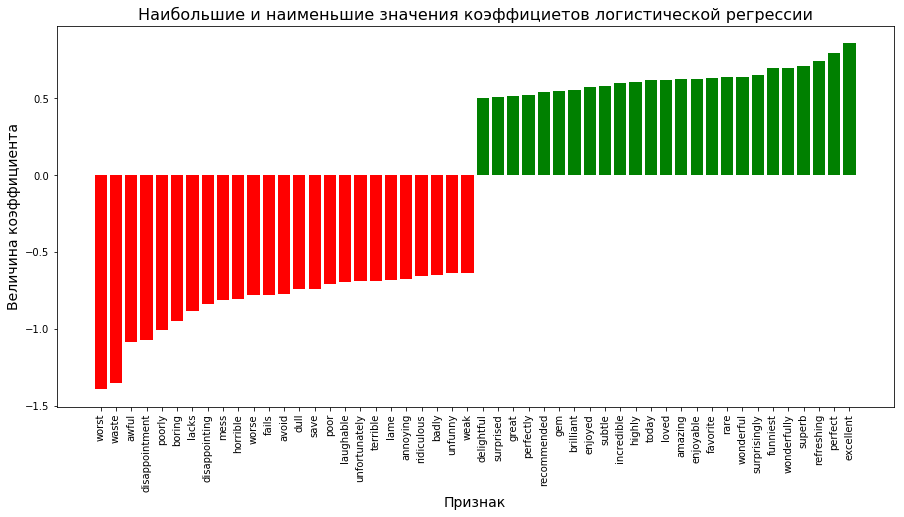

In [60]:
plt.figure(figsize=(15, 7))
plt.bar(np.append(np.array(df['feature'].iloc[:25]), 
                  np.array(df['feature'].iloc[-25:])), 
        np.append(bad_coef, best_coef),
       color=(['red']*25 + ['green']*25))
plt.xticks(rotation=90)
plt.title('Наибольшие и наименьшие значения коэффициетов логистической регрессии', 
          fontdict={'fontsize': 16})
plt.xlabel('Признак', fontdict={'fontsize': 14})
plt.ylabel('Величина коэффициента', fontdict={'fontsize': 14})
plt.show()

По визуализации видно, что модель имеет массу неинформативных признаков (например числа). Один из способов решить эту проблему - использовать только те токены, которые встречаются по крайней мере в двух документах. Токен, который встретился в одном тексте, вряд ли встретится в тестовом наборе и поэтому бесполезен.

Зададим минимальное количество документов, в которых должен появиться токен, чтобы попасть в словарь:

In [62]:
vect = CountVectorizer(min_df=5).fit(texts_train)
X_train = vect.transform(texts_train)
X_train

<25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>

Количество токенов уменьшили до 27271.

Получим доступ к признакам:

In [63]:
feature_names = vect.get_feature_names()

Посмотрим на срезы списков признаков:

In [64]:
print(feature_names[:50])

['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']


In [65]:
print(feature_names[20010:20030])

['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']


In [66]:
print(feature_names[::700])

['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciation', 'recipient', 'reviews', 'sas', 'shea', 'sneers', 'steiger', 'swastika', 'thrusting', 'tvs', 'vampyre', 'westerns']


Четко видно, что намного реже стали втречаться числа и, похоже, что исчезли некоторые странные или неправильно написанные слова.

Вновь оценим качество модели решетчатым поиском:

In [67]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, label_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Наилучшее значение точности модели при решетчатом поиске:

In [68]:
round(grid.best_score_, 2)

0.89

Наилучшие параметры регуляризации:

In [69]:
grid.best_params_

{'C': 0.1}

Веса пирзнаков в регрессии:

In [70]:
coef = grid.best_estimator_.coef_[0]
df = pd.DataFrame()
df['coef'] = coef
df['feature'] = feature_names
df = df.sort_values('coef')
df.head(10)

,coef,feature
26973,-1.391845,worst
26429,-1.365044,waste
6927,-1.091969,disappointment
1894,-1.087792,awful
18369,-1.033570,poorly
2966,-0.945927,boring
13745,-0.886826,lacks
6925,-0.827678,disappointing
15394,-0.819020,mess
11756,-0.809651,horrible


#### Визуализируем наибольшие и наименьшие значения коэффициентов логистической регрессии:

In [71]:
bad_coef = df['coef'].iloc[:25]
bad_coef

26973   -1.391845
26429   -1.365044
6927    -1.091969
1894    -1.087792
18369   -1.033570
2966    -0.945927
13745   -0.886826
6925    -0.827678
15394   -0.819020
11756   -0.809651
26965   -0.786757
8876    -0.774696
1862    -0.771251
21050   -0.739037
7622    -0.732401
13888   -0.713181
18366   -0.706726
25530   -0.693541
24278   -0.682858
13779   -0.680115
1236    -0.668640
20413   -0.659930
1977    -0.655176
25536   -0.644265
18286   -0.633948
Name: coef, dtype: float64

In [72]:
best_coef = df['coef'].iloc[-25:]
best_coef

10643    0.510434
23721    0.520690
6415     0.525456
17796    0.534284
19635    0.549956
3218     0.550655
10143    0.555641
8205     0.572409
23506    0.588187
12339    0.604779
11493    0.611252
14491    0.613555
24644    0.620185
1032     0.627917
9035     0.628893
8203     0.630090
26906    0.638716
19441    0.652785
23724    0.670233
26907    0.695492
9939     0.704649
23638    0.706516
19758    0.765520
17792    0.789033
8577     0.856581
Name: coef, dtype: float64

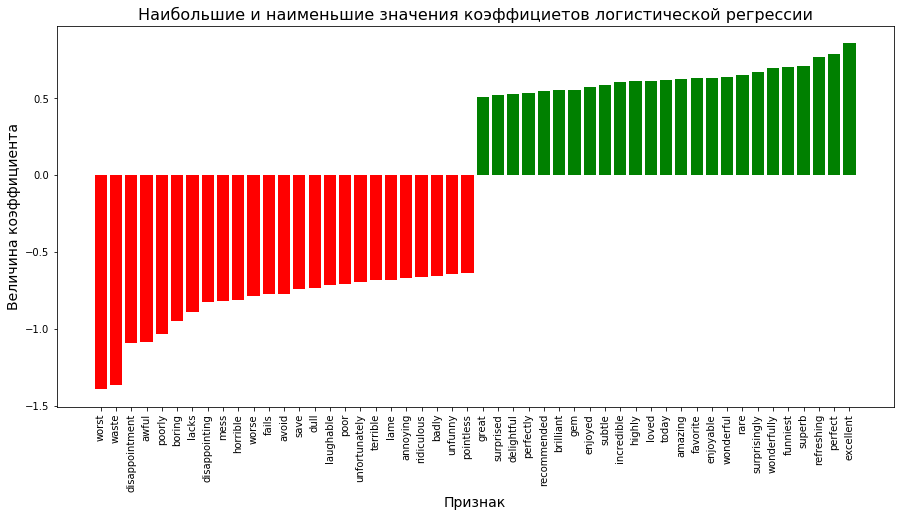

In [73]:
plt.figure(figsize=(15, 7))
plt.bar(np.append(np.array(df['feature'].iloc[:25]), 
                  np.array(df['feature'].iloc[-25:])), 
        np.append(bad_coef, best_coef),
       color=(['red']*25 + ['green']*25))
plt.xticks(rotation=90)
plt.title('Наибольшие и наименьшие значения коэффициетов логистической регрессии', 
          fontdict={'fontsize': 16})
plt.xlabel('Признак', fontdict={'fontsize': 14})
plt.ylabel('Величина коэффициента', fontdict={'fontsize': 14})
plt.show()

По визуализации видно, что модель все еще имеет массу неинформативных признаков. Таким образом мы не смогли улучшить качество модели, исключение бесполезных признаков улучшит только интерпретабельность модели.

#### Стоп-слова

Еще один способ, с помощью котрого можно избавится от неинформативных стов, - это исключение слов, которые встречаются слишком часто, чтобы быть информативными.

Библиотека sklearn предлагает встроенный список английских стоп-слов:

In [74]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

Количество стоп-слов:

In [75]:
len(ENGLISH_STOP_WORDS)

318

Список стоп слов:

In [76]:
print(list(ENGLISH_STOP_WORDS))

['either', 'system', 'themselves', 'cannot', 'therein', 'hundred', 'becoming', 'by', 'down', 'also', 'get', 'me', 'meanwhile', 'thru', 'found', 'myself', 'do', 'done', 'forty', 'ie', 'what', 'show', 'they', 'among', 'her', 'give', 'seems', 'their', 'has', 'whether', 'six', 'not', 'mostly', 'whereby', 'everywhere', 'became', 'off', 'part', 'often', 'twelve', 'the', 'behind', 'anywhere', 'him', 'within', 'formerly', 'been', 'former', 'mill', 'somehow', 'it', 'namely', 'as', 'neither', 'enough', 'in', 'ten', 'over', 'then', 'who', 'co', 'already', 'noone', 'for', 'he', 'every', 'too', 'until', 'thence', 'etc', 'toward', 'when', 'before', 'hereupon', 'so', 'during', 'hence', 'ever', 'though', 'whereafter', 'around', 'himself', 'throughout', 'once', 'with', 'anyhow', 'bill', 'had', 'serious', 'empty', 'eight', 'never', 'from', 'am', 'same', 'back', 'via', 'about', 'a', 'indeed', 'less', 'those', 'beyond', 'three', 'sometimes', 'fifteen', 'ltd', 'she', 'something', 'why', 'cry', 'whereas', '

Используем стоп слова в модели:

In [77]:
vect = CountVectorizer(min_df=5, stop_words='english').fit(texts_train)

In [78]:
X_train = vect.transform(texts_train)
X_train

<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>

In [79]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, label_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Наилучшее значение точности модели при решетчатом поиске:

In [80]:
round(grid.best_score_, 2)

0.88

Наилучшие параметры регуляризации:

In [81]:
grid.best_params_

{'C': 0.1}

Веса пирзнаков в регрессии:

In [84]:
feature_names = vect.get_feature_names()
coef = grid.best_estimator_.coef_[0]
df = pd.DataFrame()
df['coef'] = coef
df['feature'] = feature_names
df = df.sort_values('coef')
df.head(10)

,coef,feature
26157,-1.450288,waste
26675,-1.382222,worst
6861,-1.174434,disappointment
1862,-1.095869,awful
18172,-1.045804,poorly
2916,-0.914056,boring
6859,-0.867937,disappointing
8788,-0.848113,fails
26667,-0.845314,worse
13607,-0.844338,lacks


#### Визуализируем наибольшие и наименьшие значения коэффициентов логистической регрессии:

In [85]:
bad_coef = df['coef'].iloc[:25]
bad_coef

26157   -1.450288
26675   -1.382222
6861    -1.174434
1862    -1.095869
18172   -1.045804
2916    -0.914056
6859    -0.867937
8788    -0.848113
26667   -0.845314
13607   -0.844338
1830    -0.841894
15247   -0.792698
11633   -0.792291
18089   -0.769794
7552    -0.753239
20849   -0.749740
18169   -0.722957
1944    -0.718140
1215    -0.702535
25265   -0.691381
13748   -0.690499
24049   -0.672734
15111   -0.670975
20213   -0.650707
15858   -0.649228
Name: coef, dtype: float64

In [86]:
best_coef = df['coef'].iloc[-25:]
best_coef

6351     0.530856
10534    0.531582
24522    0.561145
10037    0.568602
8858     0.581042
3166     0.581855
8126     0.589574
24389    0.602490
23281    0.623104
11373    0.623864
8124     0.637690
12209    0.638302
14349    0.651570
17601    0.675735
23498    0.685200
19243    0.699326
1016     0.700451
26608    0.701558
23412    0.704385
26609    0.717986
8947     0.728881
9834     0.752622
17597    0.780852
19558    0.801375
8490     0.860257
Name: coef, dtype: float64

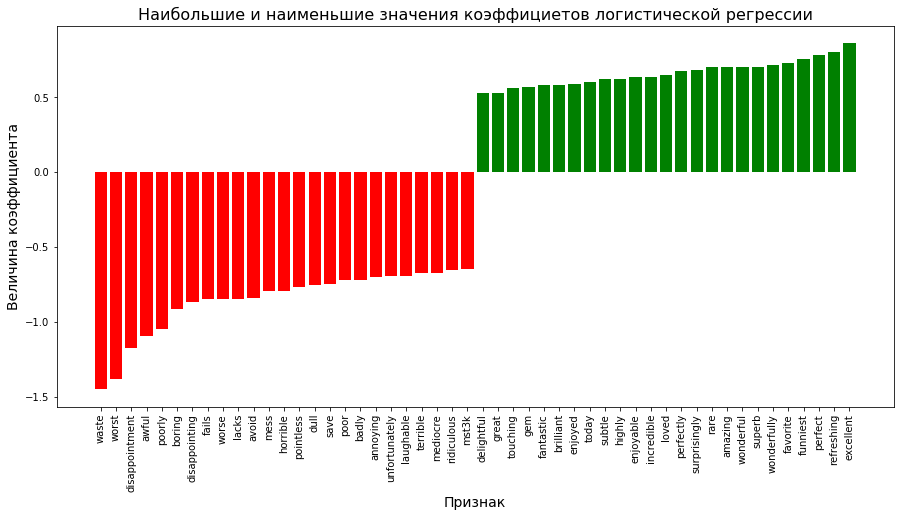

In [87]:
plt.figure(figsize=(15, 7))
plt.bar(np.append(np.array(df['feature'].iloc[:25]), 
                  np.array(df['feature'].iloc[-25:])), 
        np.append(bad_coef, best_coef),
       color=(['red']*25 + ['green']*25))
plt.xticks(rotation=90)
plt.title('Наибольшие и наименьшие значения коэффициетов логистической регрессии', 
          fontdict={'fontsize': 16})
plt.xlabel('Признак', fontdict={'fontsize': 14})
plt.ylabel('Величина коэффициента', fontdict={'fontsize': 14})
plt.show()

Видно, что использование стоп слов никак не повлияло на работу модели.

#### Масштабирование данных с помощью метода tf-idf

Идея этого метода в том, чтобы присвоить большой вес термину, который часто встречается в конкретном документе, но при этом редко встречается в остальных документах корпуса. Если слово часто появляется в конкретном документе, но при этом редко встречается в остальных документах, оно, вероятно, будет описывать содержимое документа лучше.

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [89]:
from sklearn.pipeline import make_pipeline

In [90]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), model)

In [93]:
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

In [94]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(texts_train, label_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm=None, preprocessor=None, smooth...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Наилучшее значение точности модели при решетчатом поиске:

In [95]:
round(grid.best_score_, 2)

0.89

Наилучшие параметры регуляризации:

In [96]:
grid.best_params_

{'logisticregression__C': 0.001}

Веса пирзнаков в регрессии:

In [97]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train = vectorizer.transform(texts_train)

In [98]:
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

Наименее значащие признаки:

In [99]:
vect = CountVectorizer().fit(texts_train)
feature_names = vect.get_feature_names()
feature_names = np.array(feature_names)
feature_names[sorted_by_tfidf[:25]]

array(['dictates', 'berdalh', 'clanging', 'chopped', 'competing',
       'deaths', 'bardem', '_________', 'dainton', 'forces', 'bequeathed',
       'builders', 'experts', 'adoptees', 'bochner', 'attendent',
       'beretta', 'domination', 'biographies', 'christan', 'assery',
       'exemplified', 'atoms', 'bohumil', 'copious'], dtype='<U66')

Наиболее значащие признаки:

In [100]:
feature_names[sorted_by_tfidf[-25:]]

array(['alluding', 'depletion', 'belching', 'communicative', 'earhole',
       'bacio', 'chariot', 'benella', 'casino', 'byrnes', 'faun',
       'convertible', 'fraudulently', 'cocktails', 'aggravated',
       'bijomaru', 'fetisov', 'fretwell', 'analysing', 'freuchen',
       'comedienne', 'gerda', 'durango', 'filmstrip', 'finalé'],
      dtype='<U66')

Слова, которые встречаются часто и имеют низкое значение:

In [101]:
sorted_by_idf = np.argsort(vectorizer.idf_)
feature_names[sorted_by_idf[:150]]

array(['fetisov', 'aaww', 'debiliate', 'findlay', 'fidenco',
       'clothesline', 'club', 'chrecter', 'fetishism', 'annna',
       'bulkhead', 'garnished', 'furry', 'acme', 'decimates', 'cunda',
       'dastagir', 'cbgbomfug', 'deciphering', 'agreeable', 'broken',
       'accompaniment', 'geno', '850', 'adage', 'aaawwwwnnn', 'anointing',
       'eschatological', 'bustelo', 'conkers', 'gambits', 'fibres',
       'fi9lm', 'chih', 'changeover', 'defensa', 'collen', '1961s',
       'cede', 'dedication', 'cavalryman', 'galaxina', 'established',
       'canteen', 'antiquated', 'ct', 'galigula', 'filmmmakers', 'foyt',
       'frencified', 'borel', 'deck', 'daring', 'gaydar', 'cutie',
       'elman', 'dominators', 'export', 'gallant', 'gaiday', 'caspar',
       'covington', 'fetching', 'cur', 'feuding', 'calls', 'gainful',
       'defects', 'ailed', 'bibbity', 'cuffs', 'biked', 'cetniks', '99',
       'cletus', 'browbeats', 'cookbook', 'ched', 'careered', 'ahn',
       'gangstas', 'descend', 

Как и следовало ожидать, слова с низким значением метрики - стоп-слова. Интесрено, что в соответсвии с метрикой tf-idf слово 'good' было отнесено к нерелевантным, хотя можно было ожидать, что оно будут иметь важное значение.

Коэффициенты модели:

In [107]:
coef = grid.best_estimator_.named_steps['logisticregression'].coef_[0]
coef.sort()

#### Визуализируем наибольшие и наименьшие значения коэффициентов логистической регрессии:

In [108]:
bad_coef = coef[:25]
bad_coef

array([-0.24114946, -0.18922762, -0.16882385, -0.16762892, -0.15383238,
       -0.12846837, -0.12076303, -0.12065734, -0.11784554, -0.11670615,
       -0.11564851, -0.10563196, -0.10310113, -0.10259937, -0.09954057,
       -0.09906539, -0.09890039, -0.09699585, -0.09553974, -0.09532019,
       -0.09529821, -0.09502003, -0.09368496, -0.09170486, -0.08625897])

In [109]:
best_coef = coef[-25:]
best_coef

array([0.07305831, 0.07402613, 0.07443917, 0.07468361, 0.07597944,
       0.07697095, 0.07705166, 0.07745668, 0.07789068, 0.07974711,
       0.08196403, 0.08226128, 0.0893194 , 0.09130576, 0.09207461,
       0.09370695, 0.09383512, 0.09949129, 0.10052063, 0.10236701,
       0.11059845, 0.11524024, 0.12010003, 0.1540786 , 0.16240071])

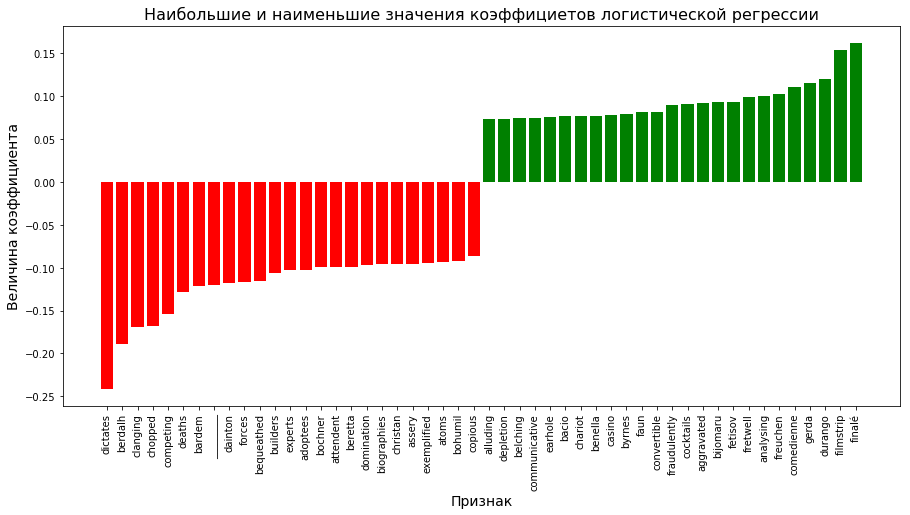

In [110]:
plt.figure(figsize=(15, 7))
plt.bar(list(feature_names[sorted_by_tfidf[:25]])+list(feature_names[sorted_by_tfidf[-25:]]), 
        np.append(bad_coef, best_coef),
       color=(['red']*25 + ['green']*25))
plt.xticks(rotation=90)
plt.title('Наибольшие и наименьшие значения коэффициетов логистической регрессии', 
          fontdict={'fontsize': 16})
plt.xlabel('Признак', fontdict={'fontsize': 14})
plt.ylabel('Величина коэффициента', fontdict={'fontsize': 14})
plt.show()